In [1]:
#for local
import sys
repo_root = "../"
if repo_root not in sys.path:
    sys.path.insert(0, repo_root)

In [2]:
%load_ext autoreload
%autoreload 2
from datetime import datetime
import importlib
import numpy as np
import logging
import os
import shutil
from typing import Any
import yaml
from rdkit import RDLogger
from generator import Generator
from language import Language, MolLanguage
from node import SurrogateNode, SentenceNode, MolSentenceNode
from utils import add_sep, class_from_package, make_logger

RDLogger.DisableLog('rdApp.*') # use debug: true to log invalid mols

def read_yaml(yaml_path: str) -> tuple[Generator, dict[str, Any]]:
    with open(os.path.join(repo_root, yaml_path)) as f:
        conf = yaml.safe_load(f)

    output_dir=os.path.join(repo_root, "sandbox", conf["output_dir"], datetime.now().strftime("%m-%d_%H-%M")) + os.sep
    file_level = logging.DEBUG if conf.get("debug") else logging.INFO
    logger = make_logger(output_dir, file_level=file_level)
    generator_args = conf.get("generator_args", {})

    transition_args = conf.get("transition_args", {})
    if "model_dir" in transition_args:
        transition_args["model_dir"] = os.path.join(repo_root, transition_args["model_dir"])
    lang_path = conf.get("lang_path")
    if lang_path is None:
        lang_name = os.path.basename(os.path.normpath(transition_args["model_dir"])) + ".lang"
        lang_path = add_sep(transition_args["model_dir"]) + lang_name
    lang = Language.load(lang_path)
    transition_class = class_from_package("transition", conf["transition_class"])
    transition = transition_class(lang=lang, logger=logger, device=conf.get("device"), **transition_args)

    reward_class = class_from_package("reward", conf.get("reward_class"))
    reward = reward_class(**conf.get("reward_args", {}))
    
    if "policy_class" in conf:
        policy_class = class_from_package("policy", conf.get("policy_class"))
        policy = policy_class(**conf.get("policy_args", {}))
        generator_args["policy"] = policy

    filter_settings = conf.get("filters", [])
    filters = []
    for s in filter_settings:
        filter_class = class_from_package("filter", s.pop("filter_class"))
        filters.append(filter_class(**s))

    if "node_class" in conf:
        node_class = class_from_package("node", conf.get("node_class"))
    elif issubclass(lang.__class__, MolLanguage):
        node_class = MolSentenceNode
    elif issubclass(lang.__class__, Language):
        node_class = SentenceNode
   
    if type(conf.get("root")) == list:
        root = SurrogateNode()
        for s in conf.get("root"):
            node = node_class.node_from_string(lang=lang, string=s, device=conf.get("device"))
            root.add_child(action=s, child=node)
    else:
        root = node_class.node_from_string(lang=lang, string=conf.get("root", ""), device=conf.get("device"))
    
    generator_class = class_from_package("generator", conf.get("generator_class", "MCTS"))
    generator = generator_class(root=root, transition=transition, reward=reward, filters=filters, output_dir=output_dir, logger=logger, **generator_args)

    src = os.path.join(repo_root, yaml_path)
    dst = os.path.join(output_dir, "setting.yaml")
    shutil.copy(src, dst)
    return generator, conf

def generate_and_analyze(generator, conf):
    generator.generate(time_limit=conf.get("time_limit"), max_generations=conf.get("max_generations"))
    generator.plot(**conf.get("plot_args", {}))
    generator.analyze()

def queue_generations(*args: str):
    for yaml_path in args:
        generator, conf = read_yaml(yaml_path)
        generate_and_analyze(generator, conf)

<frozen importlib._bootstrap>:241: RuntimeWarning: to-Python converter for boost::shared_ptr<RDKit::FilterHierarchyMatcher> already registered; second conversion method ignored.
/opt/anaconda3/envs/v3-forge/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Starting generation...
<best reward updated> order: 1, time: 0.00, reward: 0.2134, node: C[C@H](C)CN(C)C(=O)COc1cccc(C(=O)Nc2ccc(C)cc2)c1
<best reward updated> order: 2, time: 0.00, reward: 0.3325, node: O[C@@H]1CCC[C@@H]1Cc1ccccc1Cl
<best reward updated> order: 3, time: 0.00, reward: 0.3392, node: NC(=O)c1cnc2c(c1)c(=O)n(C)c(=O)n2C
<best reward updated> order: 5, time: 0.10, reward: 0.4475, node: N#Cc1ccc(F)c(C(=O)[O-])c1I
generated: 100, time: 2.31, average over 100: 0.1745
<best reward updated> order: 109, time: 2.53, reward: 0.4599, node: O[C@@H](C[NH2+][C@@H]1CCOC2(CCCC2)C1)[C@@H]1C[NH+](C)CCN1C
generated: 200, time: 4.70, average over 100: 0.2145
generated: 300, time: 7.11, average over 100: 0.1841
generated: 400, time: 9.58, average over 100: 0.1866
generated: 500, time: 12.14, average over 100: 0.2160
generated: 600, time: 14.93, average over 100: 0.1432
generated: 700, time: 17.11, average over 100: 0.2334
generated: 800, time: 19.68, average over 100: 0.1999
<best reward upda

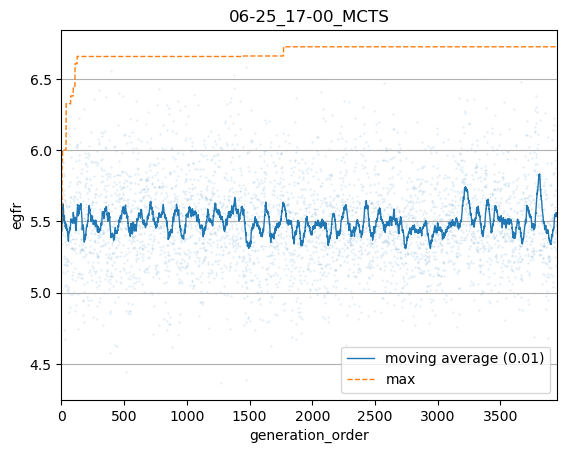

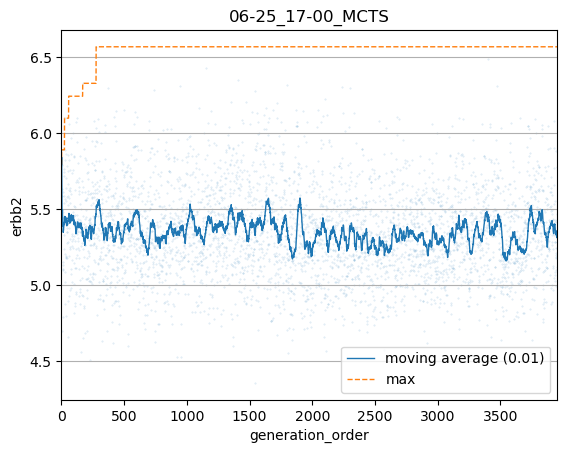

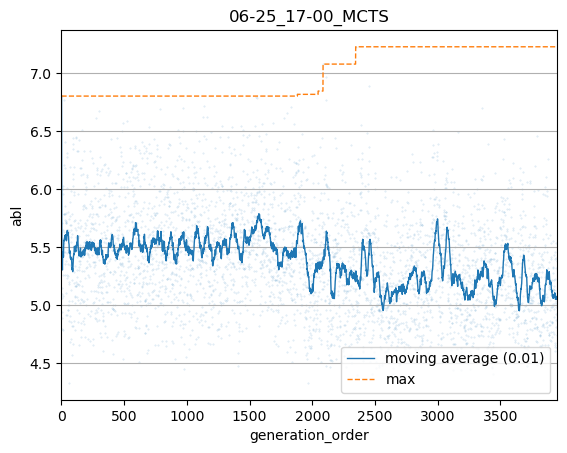

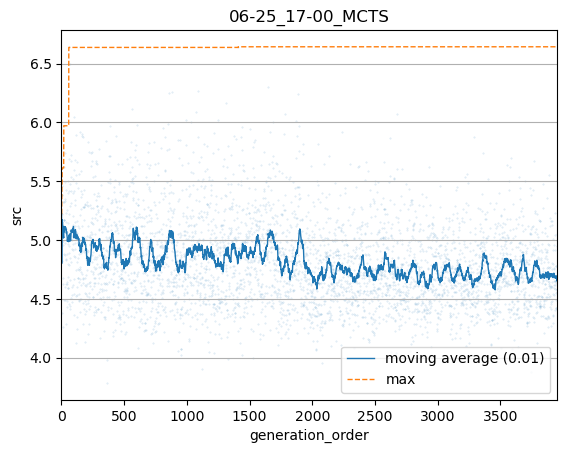

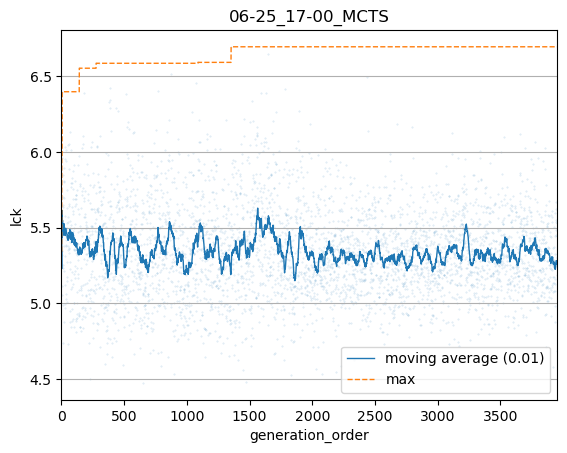

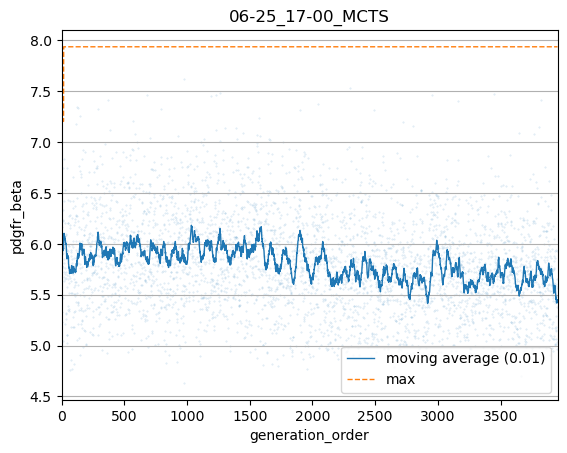

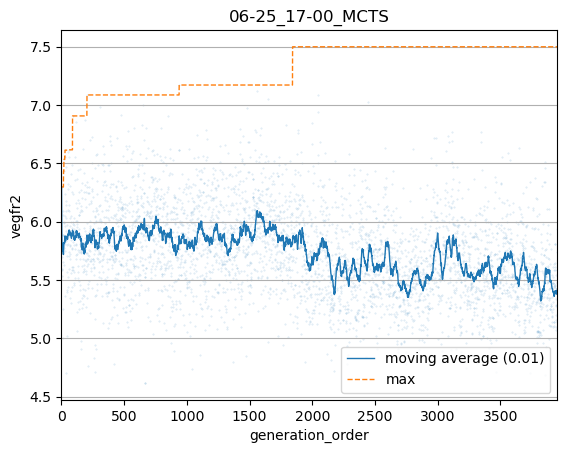

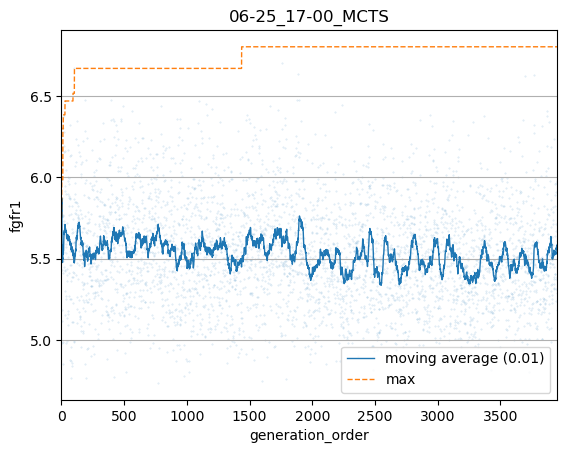

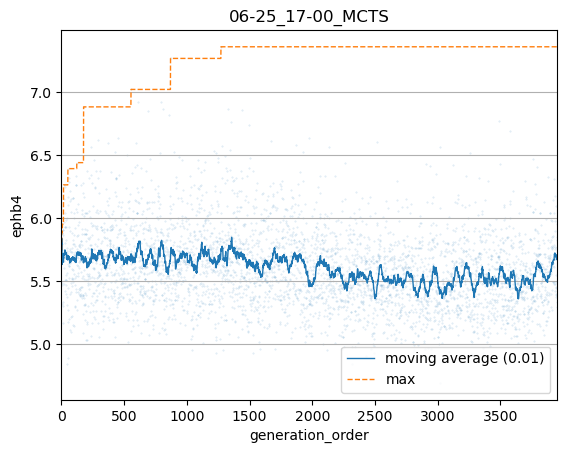

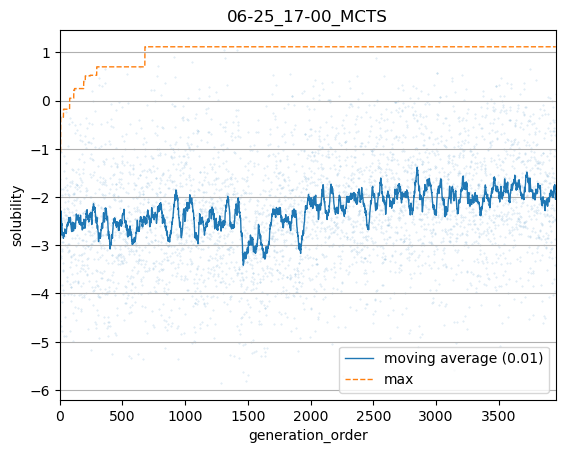

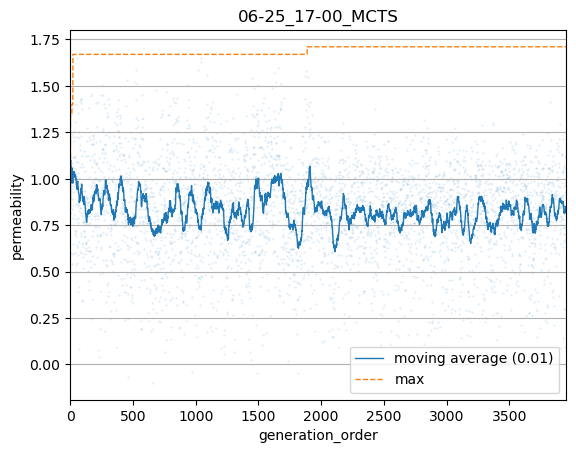

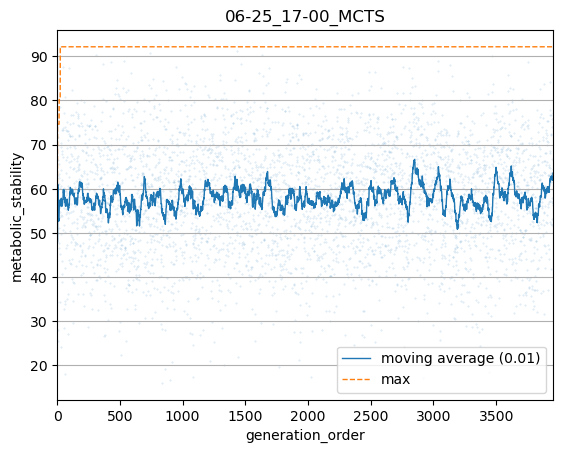

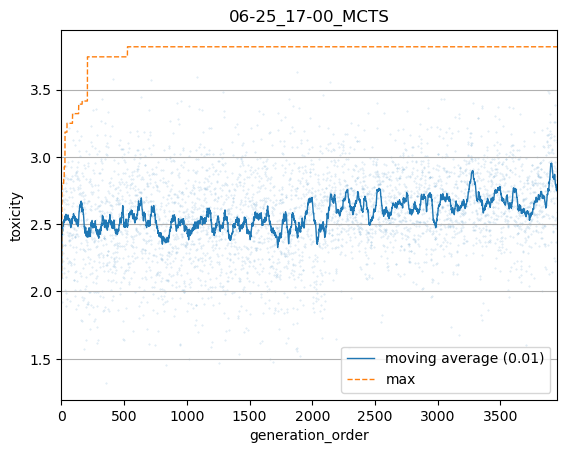

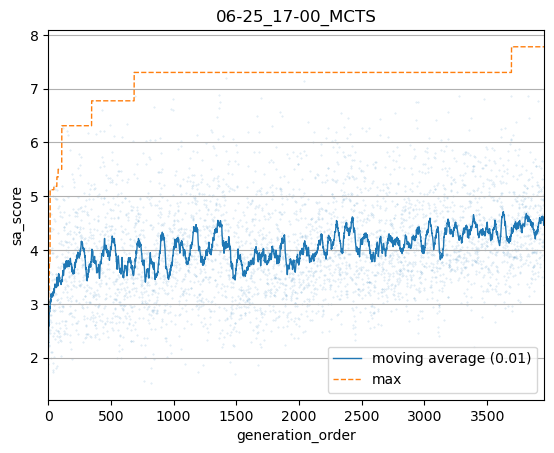

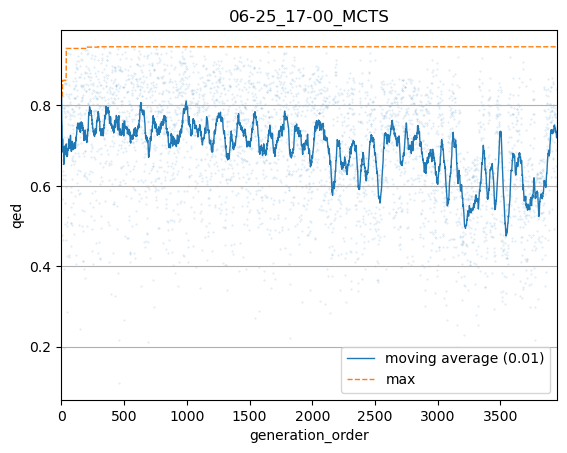

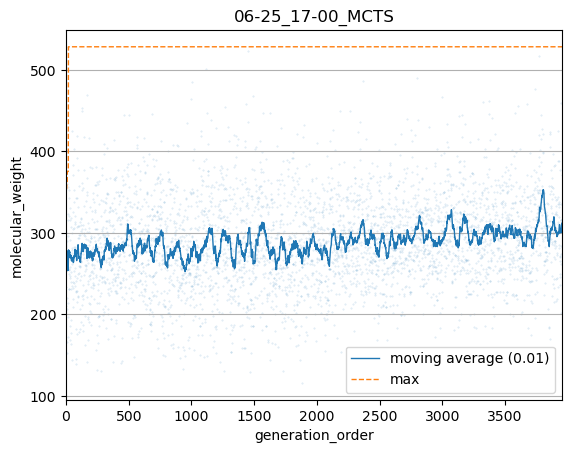

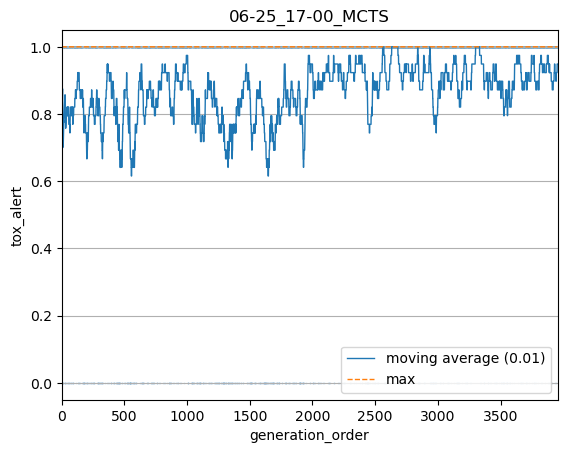

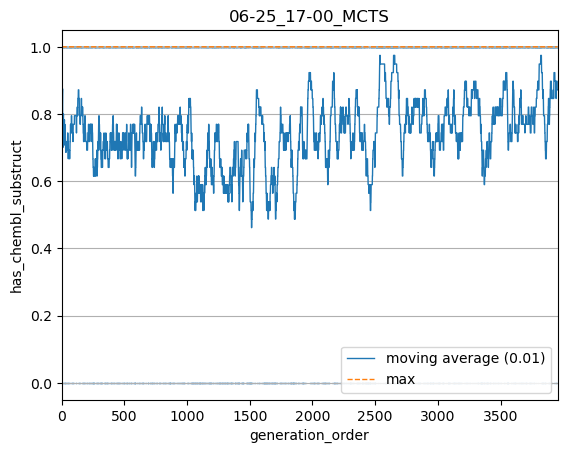

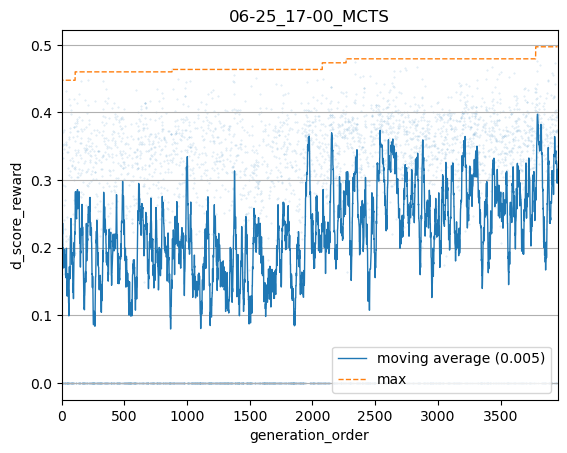

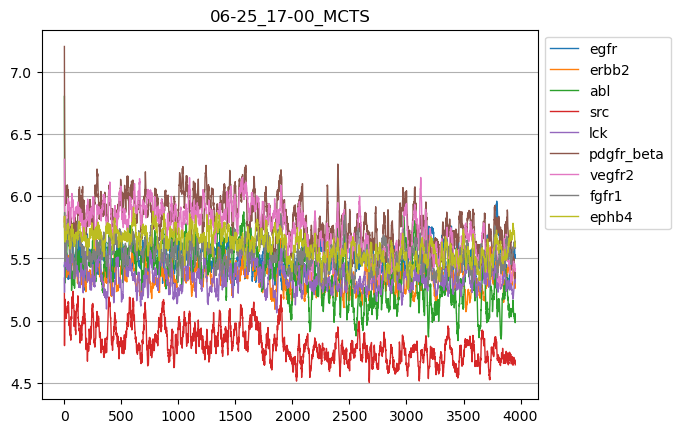

number of generated nodes: 3954
valid rate: 0.5860246623605403
unique rate: 0.9945684086905461
node_per_sec: 43.510230639789036


In [4]:
c1 = "config/mcts_d_score_replication.yaml"
c2 = "config/mcts_helm.yaml"
c3 = "config/mcts_smiles.yaml"
c4 = "config/model_test.yaml"
c5 = "config/mcts_d_score.yaml"
c6 = "config/mcts_j_score.yaml"
generator, conf = read_yaml(c5)
generate_and_analyze(generator, conf)
# queue_generations(c1, c2)

In [9]:
lang = generator.transition.lang
generator.root.show_children()
# generator.root.children[lang.token2id("C")].show_children()

0.830 C
0.128 O
0.029 N
0.005 c
0.005 [NH3+]
0.003 F


In [ ]:
#continue search
generator.generate(time_limit=conf.get("time_limit") - generator.passed_time, max_generations=conf.get("max_generations") - len(generator.unique_keys))
generator.plot(**conf.get("plot_args", {}))
generator.analyze()

In [ ]:
#save mcts
save_path = generator.output_dir() + "save.mcts"
generator.save(save_path)

In [ ]:
#load mcts test
load_path = generator.output_dir() + "save.mcts"
generator = MCTS.load(load_path, generator.transition) #TODO: separate notebook

In [ ]:
#time test
import cProfile
import pstats

profiler = cProfile.Profile()
profiler.enable()
read_yaml(c2)
profiler.disable()

stats = pstats.Stats(profiler)
stats.sort_stats("cumtime").print_stats(100)

In [222]:
#DScore test
from reward import DScoreReward
from node import MolSentenceNode
cf = "config/mcts_d_score.yaml"
generator, conf = read_yaml(cf)
string = "c1sc2ncncc2c1[C@@H](O)c1=nc(C([O-])=O)=nc(N)=n1"
x = MolSentenceNode.node_from_string(lang=generator.transition.lang, string=string, include_eos=True, device="cpu")
generator.reward.objective_values_and_reward(x)

([7.738178695018596,
  5.380680492166317,
  4.343190079318335,
  4.663313149682271,
  5.224851127291654,
  4.654329008014571,
  4.843767364097564,
  4.935388081712041,
  5.2351610291927955,
  -2.3846970086718144,
  0.991810044601756,
  63.55878775057214,
  2.521272632444819,
  3.9831675518469654,
  0.6139719804089897,
  303.283,
  1,
  1],
 0.6487755981901583)

In [223]:
string = "c1sc2ncncc2c1"
y = MolSentenceNode.node_from_string(lang=generator.transition.lang, string=string, include_eos=False, device="cpu")
t = generator.transition.transitions_with_probs(y)
for action, node, prob in t:
    print(node, prob)

c1sc2ncncc2c1- 0.055533841252326965
c1sc2ncncc2c1/ 0.028348693624138832
c1sc2ncncc2c1 0.06410867720842361
c1sc2ncncc2c1C 0.4694652259349823
c1sc2ncncc2c1F 0.0009618543554097414
c1sc2ncncc2c1I 0.0021593605633825064
c1sc2ncncc2c1N 0.19565324485301971
c1sc2ncncc2c1O 0.017446408048272133
c1sc2ncncc2c1S 0.007149592507630587
c1sc2ncncc2c1[C@@H] 0.06944021582603455
c1sc2ncncc2c1[C@@] 0.002234969986602664
c1sc2ncncc2c1[C@H] 0.05132880061864853
c1sc2ncncc2c1[C@] 0.0014879098162055016
c1sc2ncncc2c1[N-] 0.004273803438991308
c1sc2ncncc2c1[O-] 0.012141085229814053
c1sc2ncncc2c1c 0.013975519686937332
c1sc2ncncc2c1n 0.004290837794542313


In [8]:
#JScore test
from reward import DScoreReward
from node import MolSentenceNode
cf = "config/mcts_j_score.yaml"
generator, conf = read_yaml(cf)
string = "O=C(Nc1cc(Nc2c(Cl)cccc2NCc2ccc(Cl)cc2Cl)ccc1C1=CCCCC1)c1cc(F)cc(Cl)c1"
x = MolSentenceNode.node_from_string(lang=generator.transition.lang, string=string, include_eos=True, device="cpu")
generator.reward.objective_values_and_reward(x)

([11.004699999999985, 2.7979856545812734, 0], 0.8645154119818951)